In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

import tensorflow as tf
!pip install transformers

import transformers
from transformers import BertTokenizer
from transformers import TFAutoModel

from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(transformers.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.11.0
4.28.1


# 📋 Loading the Data

In [2]:
import pandas as pd
import numpy as np
!pip install gensim nltk
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('/kaggle/input/uk-twitter-covid19-dataset/sample_data.csv')
#df = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/Reddit_Data.csv')
#df = pd.read_csv('/kaggle/input/external-covid-19-twitter-dataset/Twitter_Data.csv')

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   created_at                3000 non-null   object 
 1   user_id                   3000 non-null   int64  
 2   username                  3000 non-null   object 
 3   tweet                     3000 non-null   object 
 4   place                     173 non-null    object 
 5   near                      3000 non-null   object 
 6   clean_tweet               3000 non-null   object 
 7   tokens                    3000 non-null   object 
 8   lemma                     3000 non-null   object 
 9   lemma_sentence            3000 non-null   object 
 10  pos_tag                   3000 non-null   object 
 11  lemma_sentence(with POS)  3000 non-null   object 
 12  sentiword_analysis        3000 non-null   float64
 13  vader_score               3000 non-null   float64
 14  textblob

In [4]:
#df = df.dropna()
df.head()

,created_at,user_id,username,tweet,place,near,clean_tweet,tokens,lemma,lemma_sentence,pos_tag,lemma_sentence(with POS),sentiword_analysis,vader_score,textblob_polarity,senti_textblob,senti_wordnet,senti_vader
0,2021-01-06,1063705581133934593,5herii,My kids can never say they don’t wanna do thei...,NaN,London,kids not wana homework sparkles covid sparkles...,"['kids', 'not', 'wana', 'homework', 'sparkles'...","['kid', 'not', 'wana', 'homework', 'sparkle', ...",kid not wana homework sparkle covid sparkle ba...,"[('kids', 'n'), ('not', 'r'), ('wana', 'a'), (...",kid not wana homework sparkle covid sparkle ...,-0.125,0.0634,0.0250,1,-1,1
1,2021-01-06,39230775,djalijournalist,We are not messing about with COVID-19. Wear y...,"{'type': 'Point', 'coordinates': [51.5141, -0....",London,not messing covid wear mask time london united...,"['not', 'messing', 'covid', 'wear', 'mask', 't...","['not', 'messing', 'covid', 'wear', 'mask', 't...",not messing covid wear mask time london united...,"[('not', 'r'), ('messing', 'v'), ('covid', 'n'...",not mess covid wear mask time london united ...,-0.625,0.6007,0.0875,1,-1,1
2,2021-01-06,63469953,aopapilot,@rsmck @underwatergeek @Pilotworldshop @Southe...,NaN,London,problem airfields cost remaining open verses p...,"['problem', 'airfields', 'cost', 'remaining', ...","['problem', 'airfield', 'cost', 'remaining', '...",problem airfield cost remaining open verse pot...,"[('problem', 'n'), ('airfields', 'n'), ('cost'...",problem airfield cost remain open verse pote...,-1.500,0.1779,0.0000,0,-1,1
3,2021-01-06,25303558,gilesyb,"I remain astonished by the stock market, not s...",NaN,London,remain astonished stock market not face riots ...,"['remain', 'astonished', 'stock', 'market', 'n...","['remain', 'astonished', 'stock', 'market', 'n...",remain astonished stock market not face riot i...,"[('remain', 'n'), ('astonished', 'a'), ('stock...",remain astonished stock market not face riot...,-1.125,0.6730,0.2250,1,-1,1
4,2021-01-06,262799412,chutte1,Dear lord Jesus Christ . I thank you for your ...,NaN,London,dear lord jesus christ grace listen prayers la...,"['dear', 'lord', 'jesus', 'christ', 'grace', '...","['dear', 'lord', 'jesus', 'christ', 'grace', '...",dear lord jesus christ grace listen prayer lay...,"[('dear', 'a'), ('lord', 'n'), ('jesus', 'n'),...",dear lord jesus christ grace listen prayer l...,1.000,0.8519,0.0000,0,1,1


In [5]:
df['text'] = df['clean_tweet']
df['target'] = df['senti_textblob']
#df['text'] = df['clean_text']
#df['target'] = df['airline_sentiment']

In [6]:
'''
import pandas as pd

# assuming your dataframe is named 'df'
num_samples_per_label = 2000

# group the dataframe by the label column
grouped_df = df.groupby('target')

# sample a specified number of rows from each group
sampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))

# reset the index of the resulting dataframe
sampled_df = sampled_df.reset_index(drop=True)
df = sampled_df 
'''

"\nimport pandas as pd\n\n# assuming your dataframe is named 'df'\nnum_samples_per_label = 2000\n\n# group the dataframe by the label column\ngrouped_df = df.groupby('target')\n\n# sample a specified number of rows from each group\nsampled_df = grouped_df.apply(lambda x: x.sample(n=num_samples_per_label))\n\n# reset the index of the resulting dataframe\nsampled_df = sampled_df.reset_index(drop=True)\ndf = sampled_df \n"

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[['text','target']], test_size = 0.2, random_state = 42)

In [8]:
train

,text,target
642,covid vaccine inspiration microbe syringe dizz...,0
700,couple friends suffered dealing long covid tha...,-1
226,minutes paces miles steep hill no breathing pr...,0
1697,manufactured protective masks manufactured cov...,0
1010,capitol building crawling covid,0
...,...,...
1638,hey things bit busy keeping london covid keepi...,1
1095,covid lockdown coral spawning work continues t...,0
1130,petition prioritise teachers school childcare ...,0
1294,petition prioritise key retail workers offered...,0


In [9]:
print("train, counts of label '1': {}".format(sum(train.target == 1)))
print("train, counts of label '0': {}".format(sum(train.target == 0)))
print("train, counts of label '-1': {}\n".format(sum(train.target == -1)))
print("test, counts of label '1': {}".format(sum(test.target == 1)))
print("test, counts of label '0': {}".format(sum(test.target == 0)))
print("test, counts of label '-1': {}".format(sum(test.target == -1)))

train, counts of label '1': 876
train, counts of label '0': 961
train, counts of label '-1': 563

test, counts of label '1': 227
test, counts of label '0': 238
test, counts of label '-1': 135


In [10]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

#train = reduce_mem_usage(train)
#train = reduce_mem_usage(test)

In [11]:
'''
import pandas as pd

# assume your test data is stored in a pandas DataFrame called 'test'
# and the labels are stored in a column called 'target'

# randomly sample 1000 rows from each label
label_1 = test[test.target == 1].sample(n=1000, replace=False)
label_0 = test[test.target == 0].sample(n=1000, replace=False)
label_minus_1 = test[test.target == -1].sample(n=1000, replace=False)

# concatenate the sampled rows into one DataFrame
sampled_data = pd.concat([label_1, label_0, label_minus_1])

# shuffle the DataFrame
test = sampled_data.sample(frac=1).reset_index(drop=True)
'''

"\nimport pandas as pd\n\n# assume your test data is stored in a pandas DataFrame called 'test'\n# and the labels are stored in a column called 'target'\n\n# randomly sample 1000 rows from each label\nlabel_1 = test[test.target == 1].sample(n=1000, replace=False)\nlabel_0 = test[test.target == 0].sample(n=1000, replace=False)\nlabel_minus_1 = test[test.target == -1].sample(n=1000, replace=False)\n\n# concatenate the sampled rows into one DataFrame\nsampled_data = pd.concat([label_1, label_0, label_minus_1])\n\n# shuffle the DataFrame\ntest = sampled_data.sample(frac=1).reset_index(drop=True)\n"

In [12]:
test

,text,target
1801,not job hope sadly needed current situation co...,-1
1190,black jesus cure covid,-1
1817,wedding honeymoon add rearranged times due tho...,-1
251,update dad hospital care monitored closely slo...,-1
2505,signed petition demanding government houses ro...,-1
...,...,...
104,icu nurse friend beds people hospital covid sy...,0
2087,gov trading country scientists blocked entry t...,0
599,totally agree covid bridge communicate public ...,1
1756,covid not causing issues pre january,0


In [13]:
#train2, test2 = train, test

# 🔨 Preprocessing

In [14]:
#Use regex to clean the data
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text 

def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0)     
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

train['text'] = train['text'].apply(lambda x : remove_url(x))
train['text'] = train['text'].apply(lambda x : remove_punct(x))
train['text'] = train['text'].apply(lambda x : remove_emoji(x))
train['text'] = train['text'].apply(lambda x : decontraction(x))
train['text'] = train['text'].apply(lambda x : seperate_alphanumeric(x))
train['text'] = train['text'].apply(lambda x : unique_char(cont_rep_char,x))

test['text'] = test['text'].apply(lambda x : remove_url(x))
test['text'] = test['text'].apply(lambda x : remove_punct(x))
test['text'] = test['text'].apply(lambda x : remove_emoji(x))
test['text'] = test['text'].apply(lambda x : decontraction(x))
test['text'] = test['text'].apply(lambda x : seperate_alphanumeric(x))
test['text'] = test['text'].apply(lambda x : unique_char(cont_rep_char,x))

# ✂️ Tokenization

In [15]:
seq_len = 256 #max([len(text) for text in train['text']]) #256
batch_size = 16 #16
num_samples = len(train)

model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

train_tokens = tokenizer(
    train['text'].tolist(), 
    max_length=seq_len, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True, 
    return_tensors='np'
)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['target'] = le.fit_transform(train['target'])
test['target'] = le.fit_transform(test['target'])

y_train = train['target'].values
labels = np.zeros((num_samples, y_train.max() + 1))
labels[np.arange(num_samples), y_train] = 1

dataset = tf.data.Dataset.from_tensor_slices(
    (
        train_tokens['input_ids'], 
        train_tokens['attention_mask'], 
        labels
    )
)

def map_func(input_ids, masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': masks
    }, labels

dataset = dataset.map(map_func)
dataset = dataset.shuffle(10000).batch(batch_size=batch_size, drop_remainder=True)

split = 0.7
size = int((train_tokens['input_ids'].shape[0] // batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [16]:
size

105

In [17]:
labels.shape

(2400, 3)

# 🤖 Model Building

In [18]:
'''

###### MODEL 1 ####

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = TFAutoModel.from_pretrained(model_name)

    # Two inputs
    input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

    # Transformer
    # embeddings = model.bert(input_ids, attention_mask=mask)[1]
    embeddings = model(input_ids, attention_mask=mask)[0]
    embeddings = embeddings[:, 0, :]
    #embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)

    # Classifier head
    x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
    #x = tf.keras.layers.Dropout(0.1)(x)
    y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

    bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

    # freeze bert layers
    # bert_model.layers[2].trainable = False

    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy()

    bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop]
)

'''

"\n\n###### MODEL 1 ####\n\n# detect and init the TPU\ntpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()\n# instantiate a distribution strategy\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)\n\n# instantiating the model in the strategy scope creates the model on the TPU\nwith tpu_strategy.scope():\n    model = TFAutoModel.from_pretrained(model_name)\n\n    # Two inputs\n    input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')\n    mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')\n\n    # Transformer\n    # embeddings = model.bert(input_ids, attention_mask=mask)[1]\n    embeddings = model(input_ids, attention_mask=mask)[0]\n    embeddings = embeddings[:, 0, :]\n    #embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)\n\n    # Classifier head\n    x = tf.keras.layers.Dense(512, activation='relu')(embeddings)\n    #x = tf.keras.layers.Dropout(0.1)(x)\n    y = tf.keras.layers.Dens

In [19]:
#'''

### MODEL 2 ####

model = TFAutoModel.from_pretrained(model_name)

# Two inputs
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# Transformer
embeddings = model(input_ids, attention_mask=mask)[0]
embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
#embeddings = embeddings[:, 0, :]

# Classifier head
x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)


bert_model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate= 4e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy()

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop]
)

#'''

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50
105/105 [==============================] - 146s 1s/step - loss: 0.9047 - categorical_accuracy: 0.5952 - val_loss: 0.6712 - val_categorical_accuracy: 0.7722
Epoch 2/50
105/105 [==============================] - 100s 954ms/step - loss: 0.6140 - categorical_accuracy: 0.7714 - val_loss: 0.4397 - val_categorical_accuracy: 0.8417
Epoch 3/50
105/105 [==============================] - 100s 954ms/step - loss: 0.4446 - categorical_accuracy: 0.8411 - val_loss: 0.2655 - val_categorical_accuracy: 0.9111
Epoch 4/50
105/105 [==============================] - 100s 957ms/step - loss: 0.3291 - categorical_accuracy: 0.8893 - val_loss: 0.1736 - val_categorical_accuracy: 0.9375
Epoch 5/50
105/105 [==============================] - 100s 955ms/step - loss: 0.2576 - categorical_accuracy: 0.9161 - val_loss: 0.1449 - val_categorical_accuracy: 0.9542
Epoch 6/50
105/105 [==============================] - 100s 954ms/step - loss: 0.1967 - categorical_accuracy: 0.9363 - val_loss: 0.0708 - val_categorical_

In [ ]:
'''
####### MODEL 3 #########
    
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
    bert_model = TFAutoModel.from_pretrained(model_name)

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

    # Transformer
    embeddings = bert_model(input_ids, attention_mask=mask)[0]
    embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
    embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

    # Add a BiLSTM layer
    lstm_units = 512 
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(embeddings)

    # Add Dense layers
    #x = tf.keras.layers.Dense(512, activation='relu')(lstm)
    x = tf.keras.layers.Dense(512, activation='relu')(lstm)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.05)(x)

    # Flatten the output tensor
    x = tf.keras.layers.Flatten()(x)

    # Classifier head
    outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_ids, mask], outputs=outputs)

    # Compile the model
    learning_rate = 4e-5 # 4e-5
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy()
    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy())

filepath = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 50,
    batch_size=batch_size,
    callbacks=[early_stop]
    #callbacks=[lr_callback] 
)

'''

In [19]:
'''
####### MODEL 4 #########
    
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model_name = 'cardiffnlp/twitter-roberta-base-sentiment-latest'
    bert_model = TFAutoModel.from_pretrained(model_name)

    # Input layers
    input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
    mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

    # Transformer
    embeddings = bert_model(input_ids, attention_mask=mask)[0]
    embeddings = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
    embeddings = tf.keras.layers.Reshape((1, -1))(embeddings)

    # Add a BiLSTM layer
    lstm_units = 512 
    lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(embeddings)
    attention_layer = tf.keras.layers.Attention()([lstm, lstm])

    # Add Dense layers
    #x = tf.keras.layers.Dense(512, activation='relu')(lstm)
    x = tf.keras.layers.Dense(512, activation='relu')(attention_layer)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.05)(x)

    # Flatten the output tensor
    x = tf.keras.layers.Flatten()(x)

    # Classifier head
    outputs = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_ids, mask], outputs=outputs)

    # Compile the model
    learning_rate = 4e-5 # 4e-5
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy()
    model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy())


filepath = "model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay)

# Fit the model with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 50,
    batch_size=batch_size,
    callbacks=[early_stop, callbacks_list]
    #callbacks=[lr_callback] 
)

'''

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)
All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/50


2023-05-21 18:50:52.941446: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-21 18:50:53.771615: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


512/512 [==============================] - ETA: 0s - loss: 0.4744 - categorical_accuracy: 0.8251

2023-05-21 18:52:17.015099: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-21 18:52:17.169249: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: loss improved from inf to 0.47438, saving model to model.h5
512/512 [==============================] - 129s 90ms/step - loss: 0.4744 - categorical_accuracy: 0.8251 - val_loss: 0.3687 - val_categorical_accuracy: 0.8548
Epoch 2/50
512/512 [==============================] - ETA: 0s - loss: 0.3591 - categorical_accuracy: 0.8672
Epoch 2: loss improved from 0.47438 to 0.35911, saving model to model.h5
512/512 [==============================] - 39s 75ms/step - loss: 0.3591 - categorical_accuracy: 0.8672 - val_loss: 0.2263 - val_categorical_accuracy: 0.9241
Epoch 3/50
512/512 [==============================] - ETA: 0s - loss: 0.2745 - categorical_accuracy: 0.9038
Epoch 3: loss improved from 0.35911 to 0.27451, saving model to model.h5
512/512 [==============================] - 39s 75ms/step - loss: 0.2745 - categorical_accuracy: 0.9038 - val_loss: 0.1694 - val_categorical_accuracy: 0.9520
Epoch 4/50
512/512 [==============================] - ETA: 0s - loss: 0.2210 - categorical_accur

In [ ]:
#!zip -r file.zip /kaggle/working/model.h5

In [ ]:
'''
model.load_weights('/kaggle/working/model.h5')
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 5,
    batch_size=batch_size,
    callbacks=[early_stop, callbacks_list]
    #callbacks=[lr_callback] #
)
'''

In [ ]:
#!zip -r file.zip /content/model.h5

# Model Architecture

In [20]:
bert_model = model

In [41]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

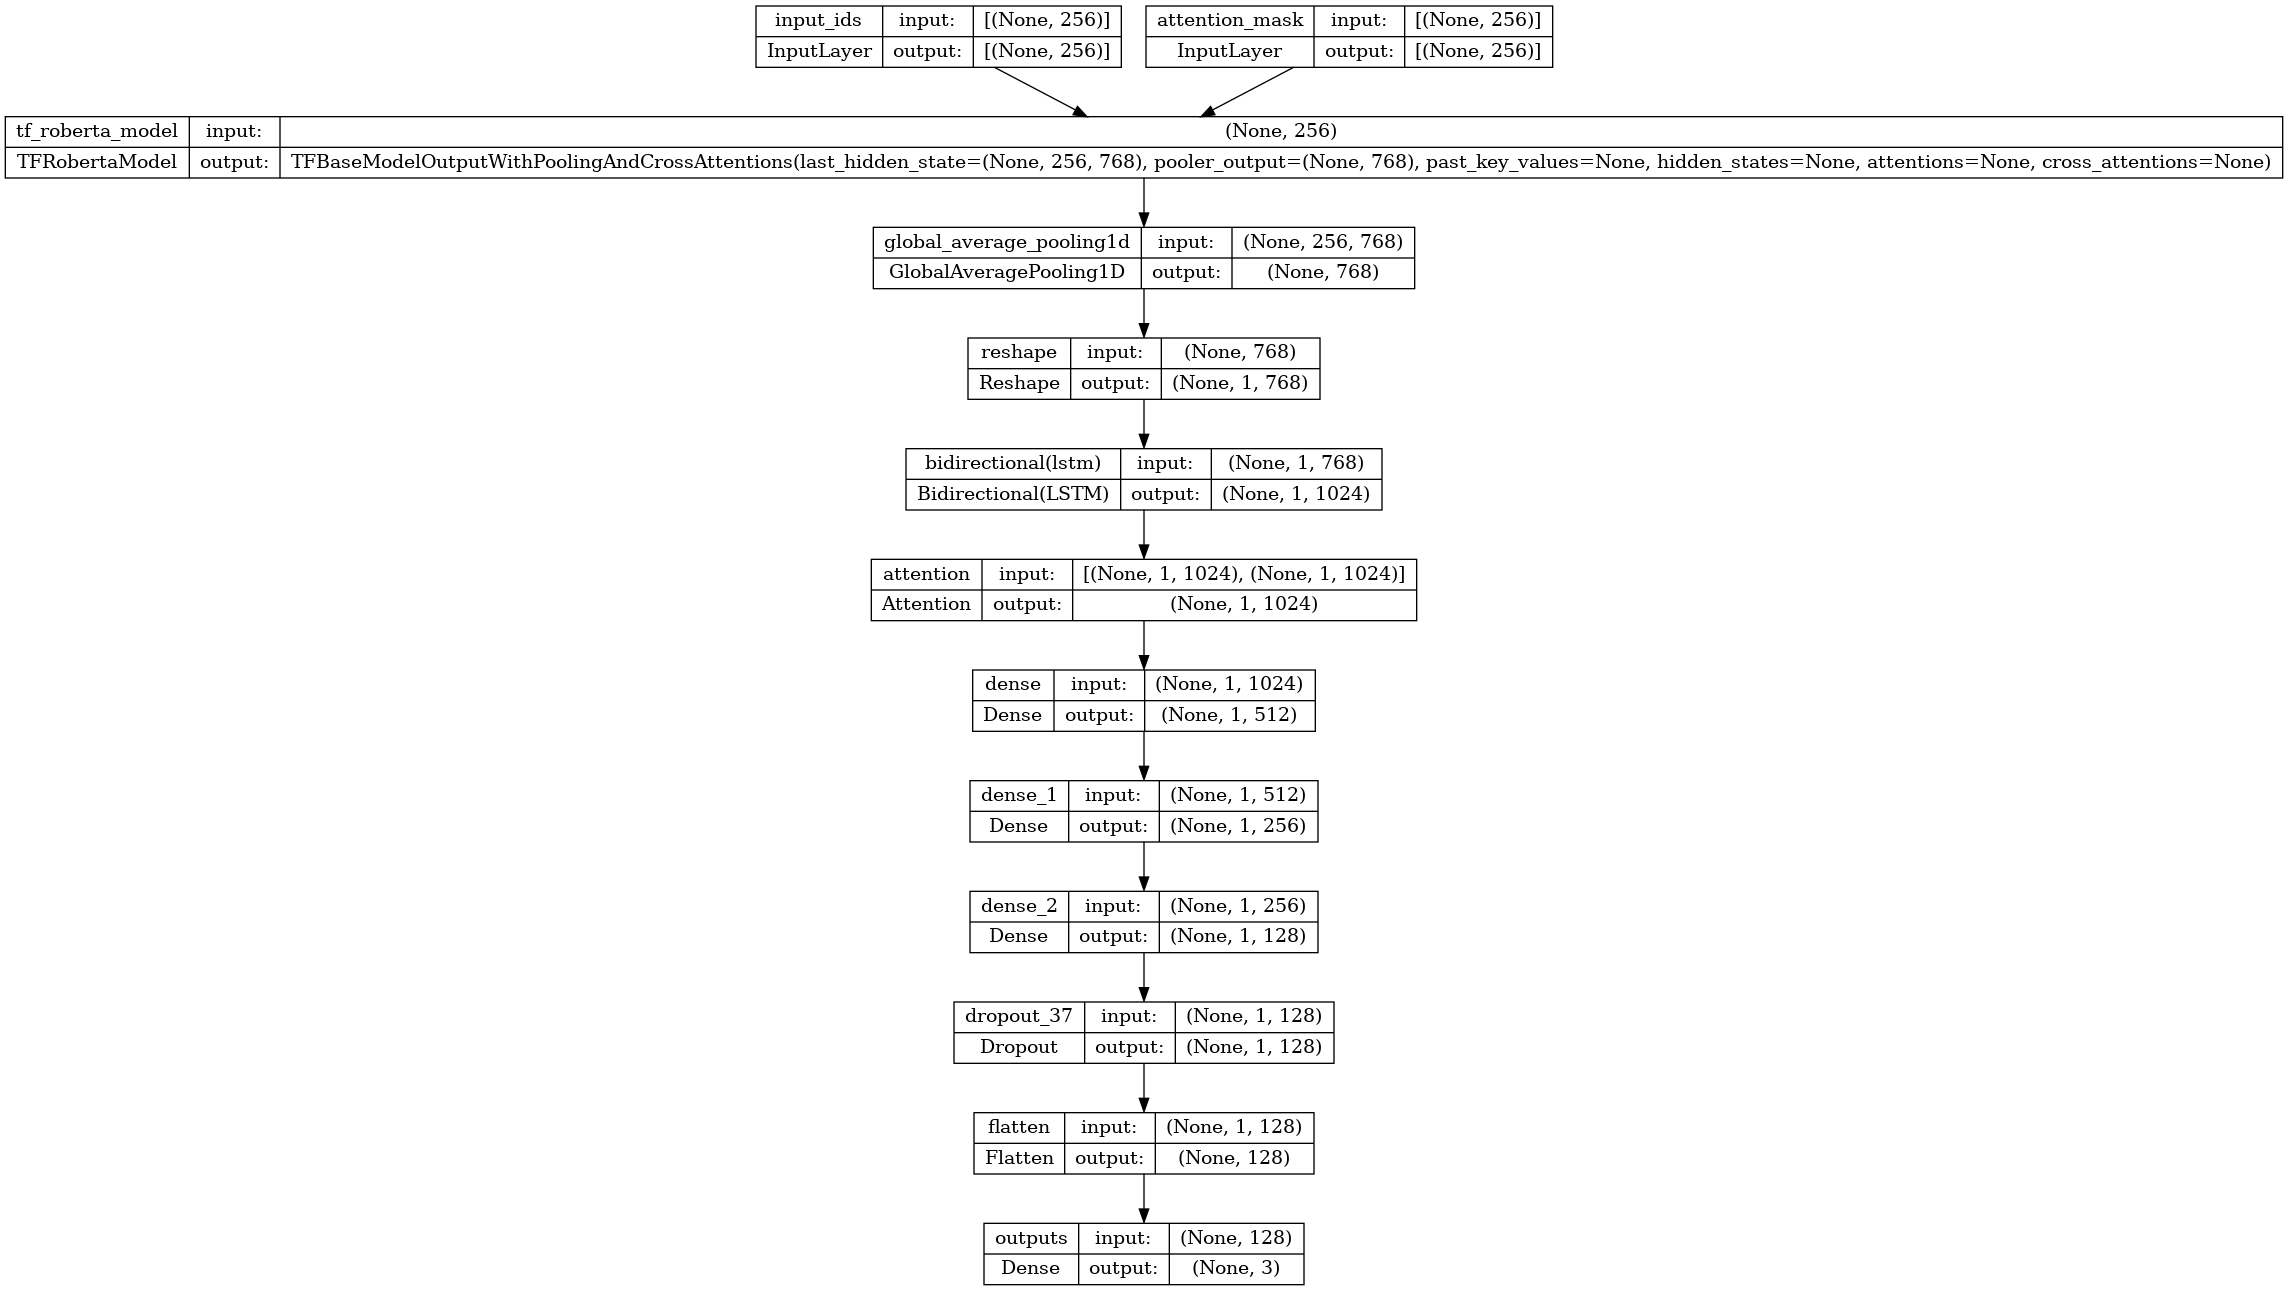

In [42]:
tf.keras.utils.plot_model(bert_model, to_file = 'bert_model1.png', show_shapes=True, show_layer_names = True)

# 📊 Model Evaluation

In [20]:
# For Data Visualization
!pip install plotly 
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import os
import random
from IPython import display

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [21]:
def plot_learning_evolution(r):
    plt.figure(figsize=(8, 6))
    
    #plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss.png')
    
    plt.figure(figsize=(8, 6))
    #plt.subplot(2, 2, 2)
    plt.plot(r.history['categorical_accuracy'], label='categorical_accuracy')
    plt.plot(r.history['val_categorical_accuracy'], label='val_categorical_accuracy')
    plt.title('Accuracy score evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('accuracy.png')

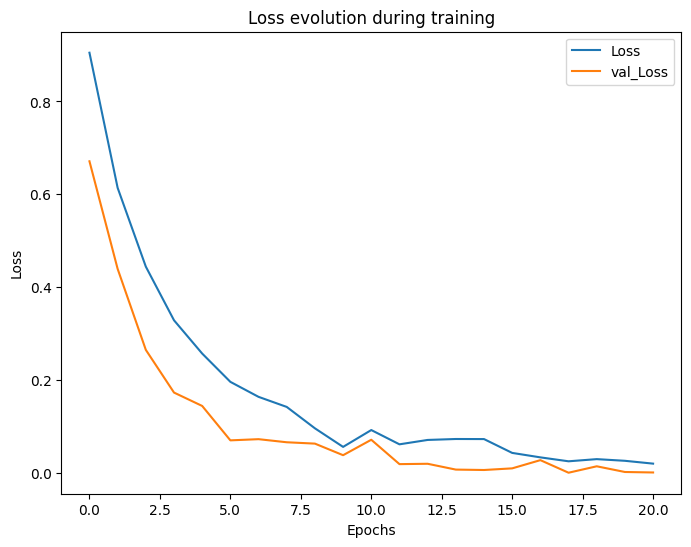

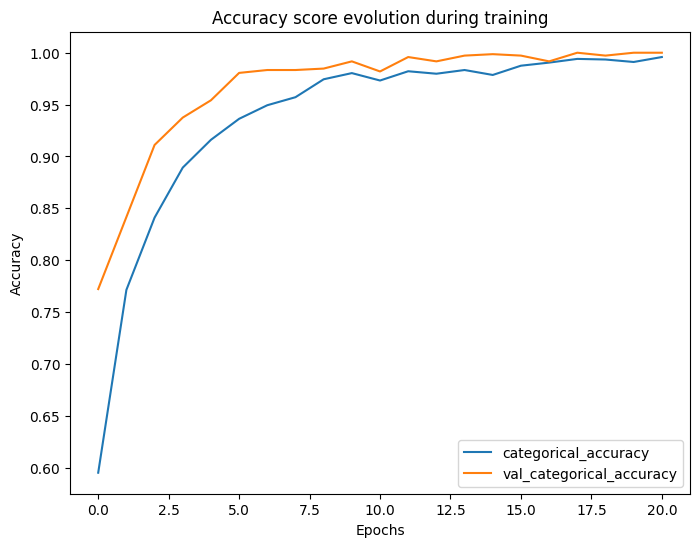

In [22]:
plot_learning_evolution(history)

In [23]:
bert_model.evaluate(val_ds)

45/45 [==============================] - 12s 263ms/step - loss: 0.0013 - categorical_accuracy: 1.0000


[0.0013350386871024966, 1.0]

In [24]:
bert_model.evaluate(train_ds)

105/105 [==============================] - 28s 269ms/step - loss: 0.0077 - categorical_accuracy: 0.9982


[0.007673947606235743, 0.9982143044471741]

In [25]:
def prep_data(text):
    tokens = tokenizer(
        text, max_length=seq_len, truncation=True, 
        padding='max_length', 
        add_special_tokens=True, 
        return_tensors='tf'
    )
    return {
        'input_ids': tokens['input_ids'], 
        'attention_mask': tokens['attention_mask']
    }

test['prediction'] = None

for i, row in test.iterrows():
    tokens = prep_data(row['text'])
    #probs = bert_model.predict(tokens)
    probs = bert_model.predict_on_batch(tokens)
    pred = np.argmax(probs)
    test.at[i, 'prediction'] = pred
    
test['prediction'] = test['prediction'].astype(int)
test

,text,target,prediction
1801,not job hope sadly needed current situation co...,0,1
1190,black jesus cure covid,0,1
1817,wedding honeymoon add rearranged times due tho...,0,0
251,update dad hospital care monitored closely slo...,0,0
2505,signed petition demanding government houses ro...,0,0
...,...,...,...
104,icu nurse friend beds people hospital covid sy...,1,1
2087,gov trading country scientists blocked entry t...,1,1
599,totally agree covid bridge communicate public ...,2,2
1756,covid not causing issues pre january,1,1


In [26]:
labels = ['Negative','Neutral','Positive']
from sklearn.metrics import classification_report
print(classification_report(test['target'], test['prediction'], target_names=labels))

              precision    recall  f1-score   support

    Negative       0.82      0.70      0.76       135
     Neutral       0.87      0.90      0.89       238
    Positive       0.83      0.87      0.85       227

    accuracy                           0.84       600
   macro avg       0.84      0.83      0.83       600
weighted avg       0.84      0.84      0.84       600



In [27]:
test.head()

,text,target,prediction
1801,not job hope sadly needed current situation co...,0,1
1190,black jesus cure covid,0,1
1817,wedding honeymoon add rearranged times due tho...,0,0
251,update dad hospital care monitored closely slo...,0,0
2505,signed petition demanding government houses ro...,0,0


In [28]:
test.target.value_counts()

1    238
2    227
0    135
Name: target, dtype: int64

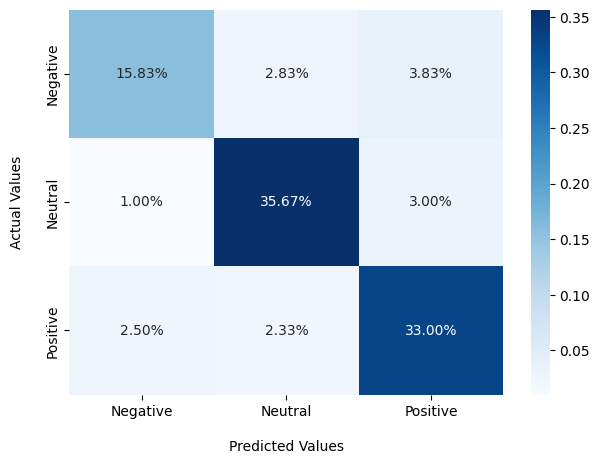

In [29]:
from sklearn.metrics import *
cm = confusion_matrix(test['target'], test['prediction'])

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.savefig('cm.png')
plt.show()

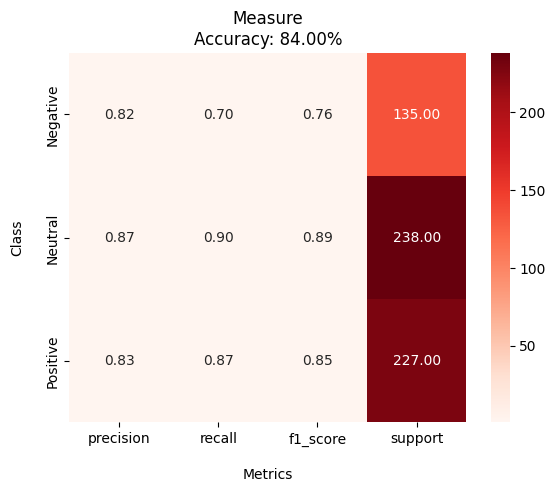

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


def plot_classification_report(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[1:-3]:
        row = {}
        row_data = line.split()
        row_data = list(filter(None, row_data))
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df.set_index('class', inplace=True)
    heatmap = sns.heatmap(df, annot=True, cmap='Reds', fmt='.2f')
    heatmap.set_xlabel('\nMetrics')
    heatmap.set_ylabel('Class\n')
    heatmap.set_title('Classification Report')


def accuracy_score(report):
    report_data = []
    lines = report.split('\n')
    lines = list(filter(None, lines))
    for line in lines[4:-2]:
        row_data = line.split()
        row_data = list(filter(None, row_data))
        return float(row_data[1])


labels = ['Negative','Neutral','Positive']

report = classification_report(test['target'], test['prediction'], target_names=labels)
plot_classification_report(report)
accuracy = accuracy_score(report)

plt.title('Measure\nAccuracy: {:.2f}%'.format(accuracy*100))
plt.savefig('classification_reports.png')
plt.show()
